c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/5 Training:  20%|█▉        | 240/1201 [24:41<1:39:41,  6.22s/it]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5  Loss: 0.5611  Train Acc: 0.7844  Val Acc: 0.8220


Epoch 2/5  Loss: 0.4226  Train Acc: 0.8511  Val Acc: 0.8099


Epoch 3/5  Loss: 0.3213  Train Acc: 0.9067  Val Acc: 0.8080


Epoch 4/5  Loss: 0.2482  Train Acc: 0.9253  Val Acc: 0.7953


Epoch 5/5  Loss: 0.1953  Train Acc: 0.9419  Val Acc: 0.8703


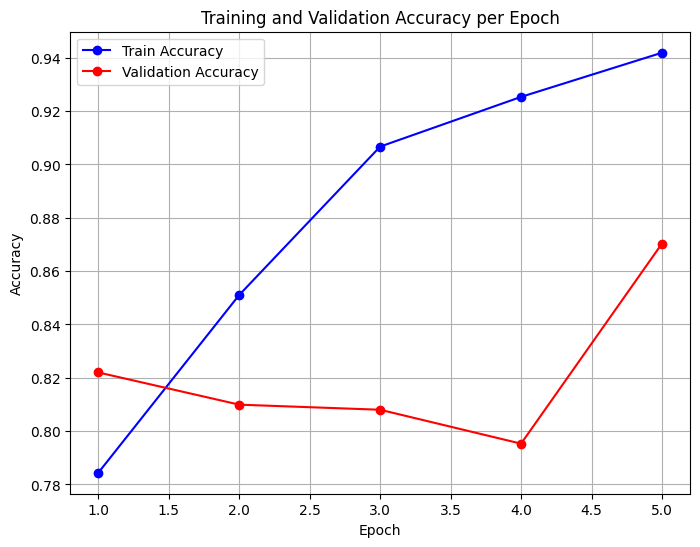

Extracting features for TSNE: 100%|██████████| 197/197 [03:52<00:00,  1.18s/it]


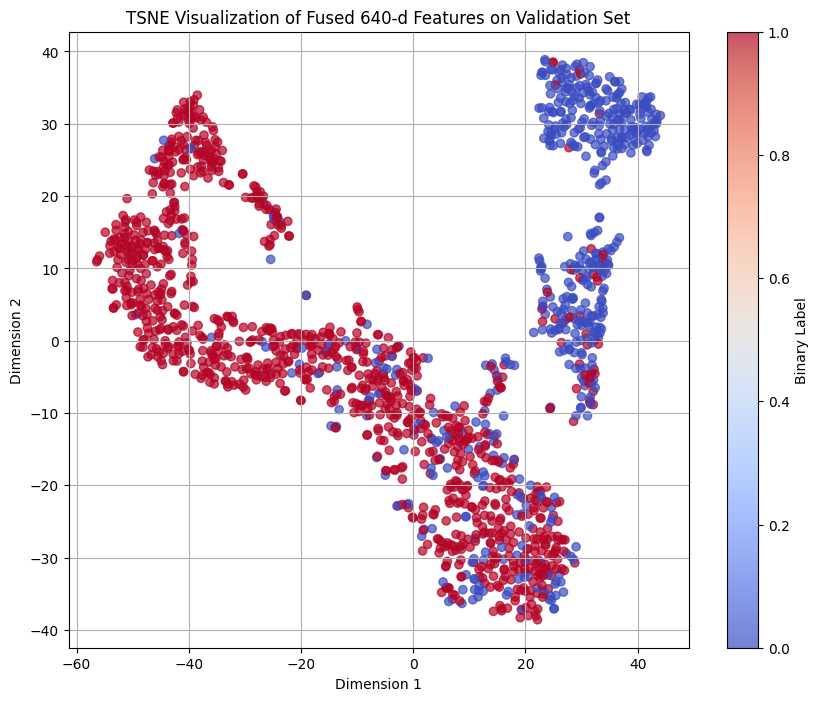

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModel
from tqdm import tqdm  # For progress bars
from sklearn.manifold import TSNE  # For TSNE visualization

# --- Load & Filter Data ---
train_data = pd.read_csv(
    'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv',
    sep='\t'
)
dev_data = pd.read_csv(
    'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv',
    sep='\t'
)

train_data = train_data[train_data['label_text_image'] == 'Positive'].reset_index(drop=True)
dev_data   = dev_data[dev_data['label_text_image'] == 'Positive'].reset_index(drop=True)
label_map = {"informative": 1, "not_informative": 0}
train_data['binary_label'] = train_data['label'].map(label_map)
dev_data['binary_label']   = dev_data['label'].map(label_map)

# --- Custom Dataset ---
class CrisisDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.data = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        tweet_text = row['tweet_text']
        image_path = row['image']
        label = int(row['binary_label'])
        
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file {image_path} not found.")
        image = Image.open(image_path).convert("RGB")
        
        inputs = self.processor(
            text=tweet_text,
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )
        # Remove extra batch dimension and add label.
        inputs = {key: tensor.squeeze(0) for key, tensor in inputs.items()}
        inputs['labels'] = torch.tensor(label, dtype=torch.float)
        return inputs

# --- Load Processor & Base Model ---
processor = AutoProcessor.from_pretrained("kakaobrain/align-base")
base_model = AutoModel.from_pretrained("kakaobrain/align-base")
hidden_size = 640  # As defined for the base model's hidden size

# --- Build Classification Model with Gated Fusion ---
class AlignForBinaryClassification(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        # Gating layer: takes the sum of text and image embeddings and outputs gate values.
        self.gate_layer = nn.Linear(hidden_size, hidden_size)
        # Classifier on the fused representation.
        self.classifier = nn.Linear(hidden_size, 1)
    
    def forward(self, input_ids, attention_mask, pixel_values):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        text_embeds = outputs.text_embeds  # (batch, hidden_dim)
        image_embeds = outputs.image_embeds  # (batch, hidden_dim)
        
        # Gated fusion
        gate = torch.sigmoid(self.gate_layer(text_embeds + image_embeds))  # (batch, hidden_dim)
        fused = gate * text_embeds + (1 - gate) * image_embeds  # (batch, hidden_dim)
        
        logits = self.classifier(fused)
        return logits
    
    def extract_features(self, input_ids, attention_mask, pixel_values):
        """
        Extracts the fused 640-d representation (used for TSNE visualization).
        """
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )
        text_embeds = outputs.text_embeds  # (batch, hidden_dim)
        image_embeds = outputs.image_embeds  # (batch, hidden_dim)
        
        gate = torch.sigmoid(self.gate_layer(text_embeds + image_embeds))
        fused = gate * text_embeds + (1 - gate) * image_embeds
        return fused

# --- Prepare DataLoaders ---
train_dataset = CrisisDataset(train_data, processor)
val_dataset   = CrisisDataset(dev_data, processor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

# --- Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlignForBinaryClassification(base_model).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# --- Training Loop ---
num_epochs = 5
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training loop with progress bar.
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * input_ids.size(0)
        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_acc = correct / total
    train_acc_history.append(train_acc)
    avg_loss = running_loss / total

    model.eval()
    val_correct, val_total = 0, 0
    # Validation loop with progress bar.
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)
            logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=pixel_values
            )
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    val_acc_history.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}  Loss: {avg_loss:.4f}  Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

# --- Plot Accuracy per Epoch ---
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc_history, 'bo-', label='Train Accuracy')
plt.plot(epochs_range, val_acc_history, 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- TSNE Visualization of Fused Features ---
# Extract features from the validation set using the model's extract_features() method.
all_features = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Extracting features for TSNE"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)
        features = model.extract_features(input_ids, attention_mask, pixel_values)
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

# Concatenate all features and labels.
all_features = torch.cat(all_features, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Apply TSNE to reduce the fused 640-d features to 2D for visualization.
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features.numpy())

# Plot TSNE results.
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels.numpy(), cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Binary Label')
plt.title("TSNE Visualization of Fused 640-d Features on Validation Set")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

# --- Load the Test Data ---
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'
test_data = pd.read_csv(test_file_path, sep='\t')

# Filter to test samples where label_text_image is 'Positive'
test_data_positive = test_data[test_data['label_text_image'] == 'Positive'].reset_index(drop=True)

# Map text labels to binary labels (same mapping as in training)
label_map = {"informative": 1, "not_informative": 0}
test_data_positive['binary_label'] = test_data_positive['label'].map(label_map)

# --- Create the Test Dataset and DataLoader ---
# Assumes CrisisDataset and processor are already defined and imported from your training code.
test_dataset = CrisisDataset(test_data_positive, processor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# --- Evaluate the Model on the Test Data ---
model.eval()  # Set model to evaluation mode
all_preds = []
all_true = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing on Positive Data"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)  # Ground truth labels

        # Forward pass
        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        # Apply sigmoid and threshold at 0.5 to get binary predictions
        preds = (torch.sigmoid(logits) > 0.5).float()

        # Store predictions and ground truth
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Convert lists to numpy arrays and flatten if necessary
all_preds = np.array(all_preds).flatten()
all_true = np.array(all_true).flatten()

# --- Compute Evaluation Metrics ---
accuracy = accuracy_score(all_true, all_preds)
conf_matrix = confusion_matrix(all_true, all_preds)
f1 = f1_score(all_true, all_preds)
precision = precision_score(all_true, all_preds)
recall = recall_score(all_true, all_preds)

# --- Print the Results ---
print("Test Metrics on 'Positive' label_text_image Test Data:")
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Testing on Positive Data:   1%|          | 1/192 [00:01<04:57,  1.56s/it]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Testing on Positive Data: 100%|██████████| 192/192 [03:54<00:00,  1.22s/it]

Test Metrics on 'Positive' label_text_image Test Data:
Accuracy: 0.8846
Confusion Matrix:
[[377 127]
 [ 50 980]]
F1 Score: 0.9172
Precision: 0.8853
Recall: 0.9515
